In [ ]:
import pandas as pd

# Illustrative Example

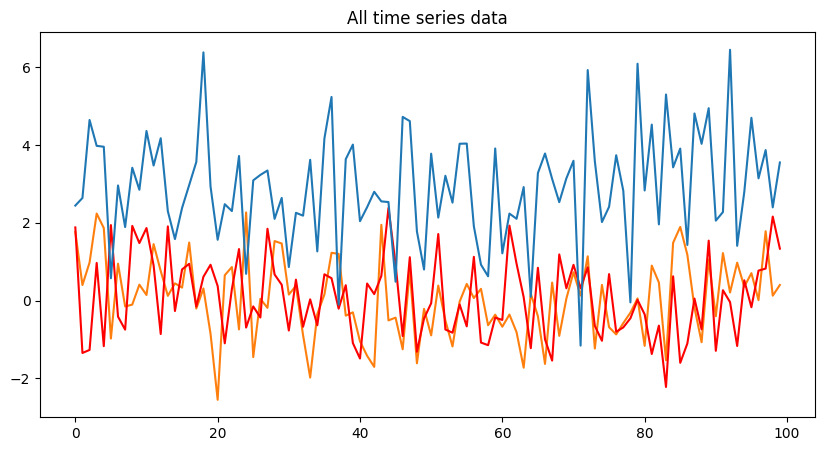

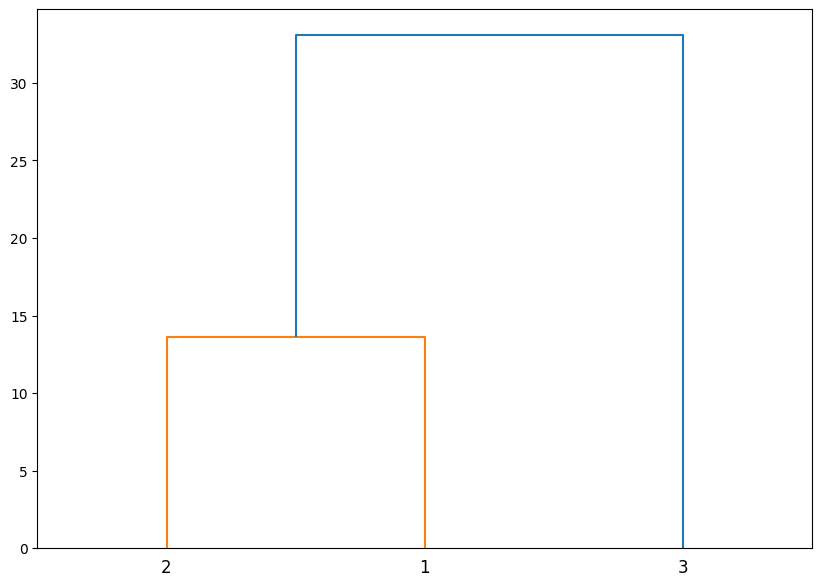

Labels from KMeans:  [0 0 1]


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

# Generate 3 univariate time series
np.random.seed(0)
time_series1 = np.random.normal(0, 1, 100)
time_series2 = np.random.normal(0, 1, 100)
time_series3 = np.random.normal(3, 1.5, 100)

# Stack the time series for clustering
time_series_data = np.vstack([time_series1, time_series2, time_series3])

color=['C1', 'red', 'C0']

# Plot time series
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(time_series_data[i], color=color[i])
plt.title('All time series data')
plt.show()

# Perform hierarchical clustering
linked = linkage(time_series_data, 'single')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linked, orientation='top', labels=range(1, 4), distance_sort='descending', show_leaf_counts=True)
plt.show()

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(time_series_data)

# Print the labels
print("Labels from KMeans: ", kmeans.labels_)


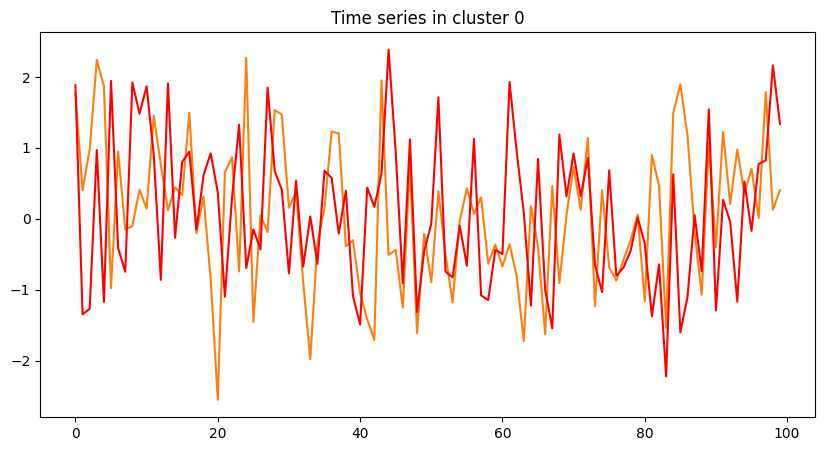

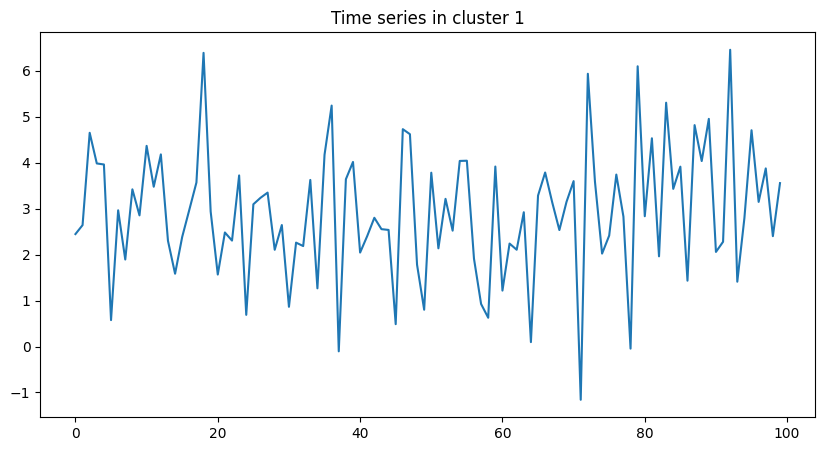

In [8]:
# Plot the time series according to their clusters
labels = kmeans.labels_
for i in range(2):  # change this to the number of clusters
    plt.figure(figsize=(10, 5))
    for j in range(len(labels)):
        if labels[j] == i:
            plt.plot(time_series_data[j], color=color[j])
    plt.title(f"Time series in cluster {i}")
    plt.show()

# Now with Optiver Data

In [105]:
path_to_data = "data/train.csv"
data = pd.read_csv(path_to_data)

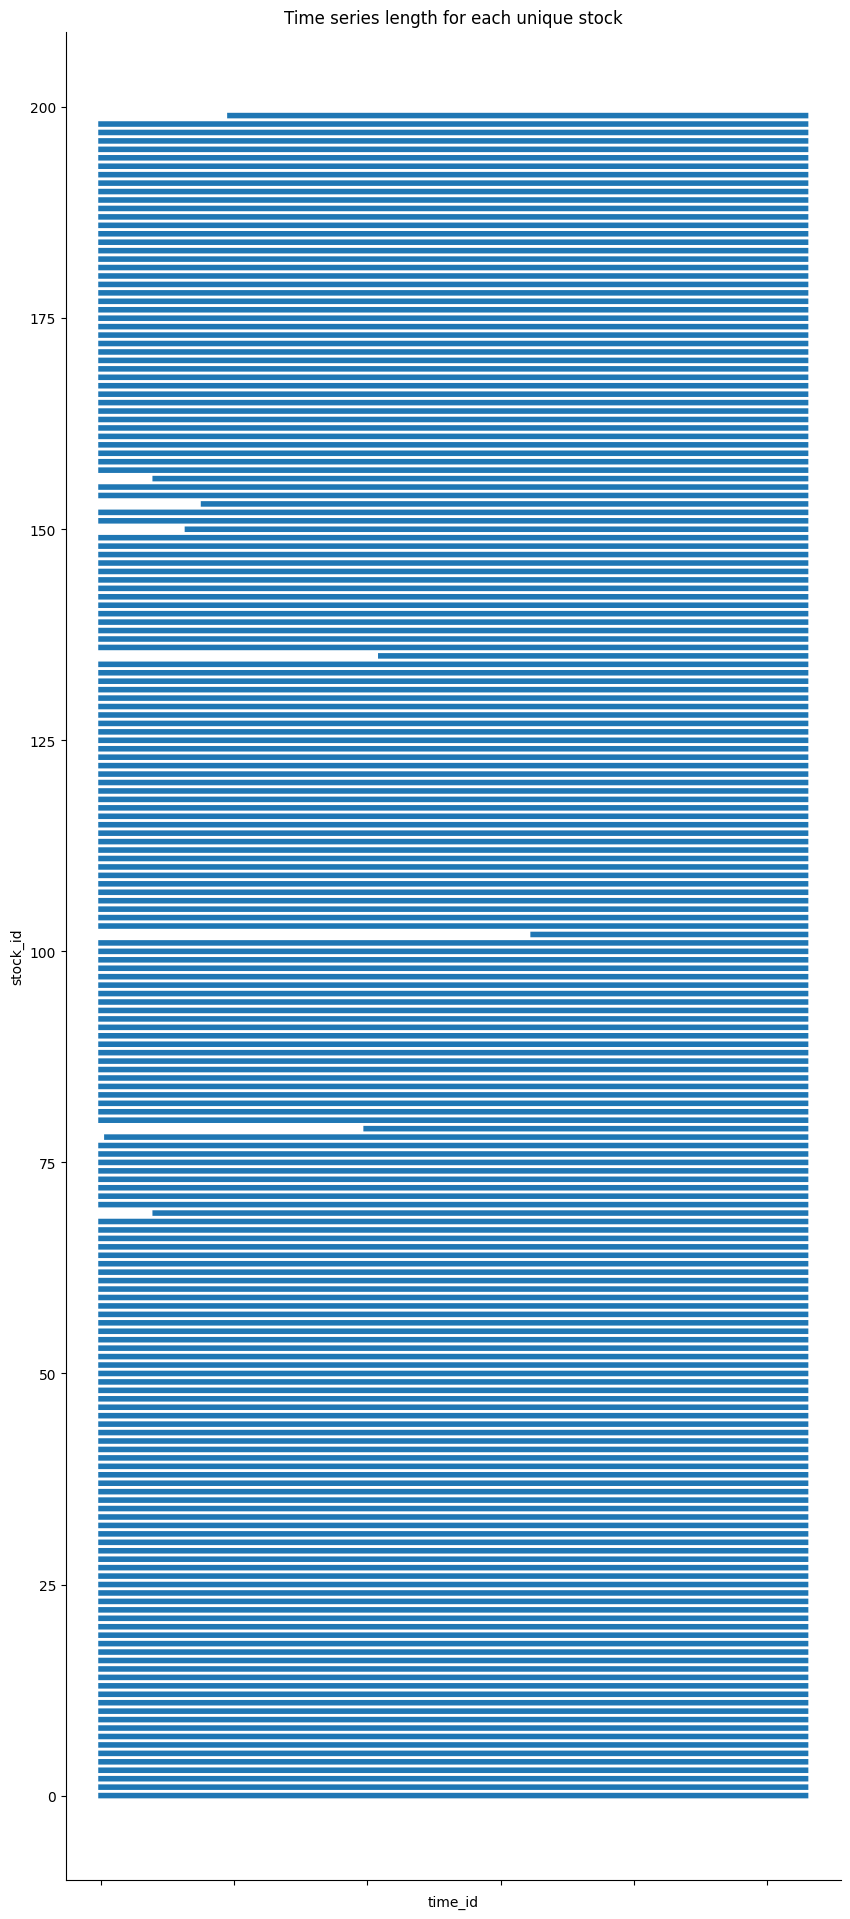

In [106]:
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and it has columns 'time_id' and 'stock_id'
plt.figure(figsize=(10,24))
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)  # Remove top spine
ax.spines['right'].set_visible(False)  # Remove right spine
ax.xaxis.set_ticklabels([])  # Remove x-axis labels

for stock_id in data['stock_id'].unique():
    stock_data = data[data['stock_id'] == stock_id]
    plt.plot(stock_data['time_id'], [stock_id]*len(stock_data), lw=4, color='C0')

plt.xlabel('time_id')
plt.ylabel('stock_id')
plt.title('Time series length for each unique stock')
plt.show()


In [107]:
# Truncate data on the highest 'time_id' starting value for the time series and
# truncate from the top as well, so all time series have the same dimention

# Find the maximum 'time_id' at which a time series starts
max_start_time_id = data.groupby('stock_id')['time_id'].min().max()

# Find the minimum 'time_id' at which a time series ends
min_end_time_id = data.groupby('stock_id')['time_id'].max().min()

# Truncate all time series to start from 'max_start_time_id' and end at 'min_end_time_id'
data_truncated = data[(data['time_id'] >= max_start_time_id) & (data['time_id'] <= min_end_time_id)]


In [52]:
lengths = data_truncated.groupby('stock_id')['target'].count()

# Check if all lengths are the same
if lengths.nunique() == 1:
    print("All time series have the same length.")
else:
    print("Not all time series have the same length.")


Not all time series have the same length.


We need to 'pad' the missing values in the time series! But first we deal with the missing values

In [53]:
# calculate the percentage of missing values in each column of the truncated data
missing_values = data_truncated.isnull().mean() * 100
print(missing_values)

stock_id                   0.0
date_id                    0.0
seconds_in_bucket          0.0
imbalance_size             0.0
imbalance_buy_sell_flag    0.0
reference_price            0.0
matched_size               0.0
far_price                  0.0
near_price                 0.0
bid_price                  0.0
bid_size                   0.0
ask_price                  0.0
ask_size                   0.0
wap                        0.0
target                     0.0
time_id                    0.0
row_id                     0.0
dtype: float64


In [108]:
# compute target median value
median_target = data.target.median()
# replace target missing values with median value
data_truncated.target.fillna(median_target, inplace=True)

/tmp/ipykernel_42/828280094.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_truncated.target.fillna(median_target, inplace=True)


Now, padded data

In [109]:
max_length = max(lengths)
data_padded = pd.DataFrame()

for stock_id in data_truncated['stock_id'].unique():
    stock_data = data_truncated[data_truncated['stock_id'] == stock_id]['target'].values
    # Pad the time series with 0 to make them the same length
    stock_data_padded = np.pad(stock_data, (0, max_length - len(stock_data)), 'constant', constant_values=0)
    data_padded = pd.concat([data_padded, pd.DataFrame(stock_data_padded).T])

# Reset the index of the new DataFrame
data_padded.reset_index(drop=True, inplace=True)

In [110]:
data_padded

,0,1,2,3,4,5,6,7,8,9,...,10220,10221,10222,10223,10224,10225,10226,10227,10228,10229
0,7.699728,-3.510117,3.000498,1.169443,1.549721,-0.429750,-0.180006,-0.860095,-0.830293,-0.290275,...,-0.609756,-0.640154,0.139475,0.300407,1.469850,3.999472,3.190041,-0.169873,3.110170,0.760555
1,-7.339716,-11.000037,5.589724,10.199547,19.379854,19.409657,19.019842,14.779568,8.590221,9.080172,...,-13.530254,-4.940033,-7.879734,0.779629,0.560284,2.850294,3.169775,5.689859,10.650158,15.859604
2,-6.229877,-12.789965,2.809763,-14.740229,-18.259884,-16.729832,-11.330247,7.840395,-1.119971,14.610291,...,1.280308,0.230074,-3.690124,-2.809763,-2.419949,-4.450083,-5.559921,-5.310178,-5.239844,-1.549721
3,-7.719994,1.039505,3.819466,2.280474,3.210306,-1.069903,5.739927,-4.640222,-3.290176,-0.939965,...,-3.650188,-5.289912,-4.280209,-2.449751,-2.549887,1.720190,4.669428,5.639792,5.229711,3.160238
4,-10.269880,-5.649924,-5.329847,-4.760027,-3.010035,-3.299713,-0.069737,-0.900030,-0.060201,2.850294,...,-0.830293,-0.090003,1.529455,2.889633,2.720356,1.939535,2.139807,1.660585,0.300407,1.009703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-5.750060,-1.800060,-1.800060,-7.209778,-4.280209,-2.639890,3.060103,-3.010035,2.620220,5.919933,...,-1.559854,-0.209808,0.439882,-1.389980,0.950098,3.190041,3.770590,1.449585,4.019737,2.310276
196,-10.420084,-0.219941,0.729561,-3.280044,-1.249909,-2.040267,-0.699758,-2.819896,-4.429817,0.480413,...,4.600287,6.159544,2.239943,1.319647,2.629757,-1.659989,-3.039837,-6.319881,-7.349849,-8.220077
197,-10.240078,-6.629825,1.300573,3.410578,12.279749,16.629696,13.250113,11.980534,9.460449,14.979839,...,1.330376,-2.269745,-2.139807,-3.259778,-0.839829,-0.690222,-3.299713,-1.999736,-3.259778,1.169443
198,6.979704,5.270243,3.830195,-0.399947,-3.479719,-5.970001,-3.020167,-3.749728,-0.849962,1.549721,...,-0.730157,0.849962,-2.509952,-2.020001,-4.019737,-2.700090,-2.070069,-2.239943,-3.160238,-1.540184


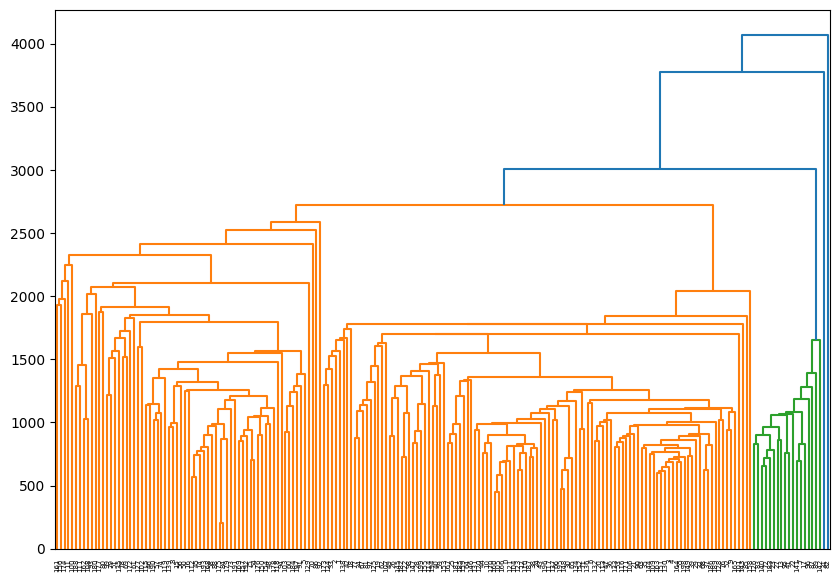

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Labels from KMeans:  [2 2 2 2 2 1 2 0 2 2 2 4 2 4 1 1 1 0 2 2 2 2 4 4 2 2 2 4 2 2 2 3 2 2 2 2 2
 2 2 2 1 4 2 2 2 1 2 2 1 2 1 1 2 2 2 2 2 2 1 2 1 5 2 2 2 2 2 2 2 1 2 2 4 2
 2 2 2 2 2 1 2 2 7 4 1 2 1 4 1 4 2 1 6 2 2 4 4 2 9 2 1 2 1 1 2 2 2 2 8 2 2
 8 2 2 2 2 2 2 1 2 2 2 9 2 2 2 4 1 2 1 2 2 2 2 2 1 2 2 1 2 4 4 4 2 2 2 2 2
 2 2 2 2 2 2 2 2 1 1 2 2 2 1 8 2 2 2 2 2 1 2 2 2 1 2 1 1 1 2 1 1 2 2 9 4 1
 2 2 2 8 2 2 1 2 1 2 2 2 1 2 2]


In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

# Assuming 'data_padded' is your padded DataFrame
# Convert the DataFrame to a numpy array for clustering
time_series_data = data_padded.values

# Perform hierarchical clustering
linked = linkage(time_series_data, 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

# Apply KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=0).fit(time_series_data)

# Print the labels
print("Labels from KMeans: ", kmeans.labels_)


In [137]:
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Assuming 'data_padded' is your padded DataFrame
# Convert the DataFrame to a numpy array for clustering
time_series_data = data_padded.values
# Truncate the time series data to only have 1000 time steps (and converges in useful time)
time_series_data = time_series_data[:, :1000]

# Normalize the data
scaler = StandardScaler()
time_series_data = scaler.fit_transform(time_series_data)

# Reshape data for TimeSeriesKMeans
time_series_data = time_series_data.reshape((time_series_data.shape[0], time_series_data.shape[1], 1))

# Use TimeSeriesKMeans with DTW
kmeans = TimeSeriesKMeans(n_clusters=10, metric="dtw", max_iter=5, random_state=0)
kmeans.fit(time_series_data)

# Print the labels
print("Labels from KMeans: ", kmeans.labels_)


Labels from KMeans:  [4 2 7 4 4 1 1 1 7 4 4 2 4 4 4 4 7 1 7 2 4 4 7 4 4 4 4 3 3 4 4 5 4 0 1 4 4
 4 4 4 1 3 2 4 3 4 7 1 4 4 1 2 3 4 3 4 1 3 3 1 4 0 2 4 1 4 3 1 4 1 9 4 4 4
 1 4 3 3 7 3 2 2 6 4 4 2 0 3 1 3 1 1 9 3 6 4 1 7 1 3 2 2 2 7 4 4 4 2 7 4 4
 2 4 4 7 7 4 7 0 2 3 4 1 4 1 7 3 2 3 0 4 4 1 3 3 2 3 4 2 3 4 1 4 8 3 1 7 1
 4 4 4 4 3 2 4 7 1 4 6 1 4 0 7 4 4 3 1 4 4 3 4 4 0 1 0 4 4 2 4 3 2 1 3 4 1
 1 4 4 2 4 7 4 4 4 1 4 4 3 4 3]


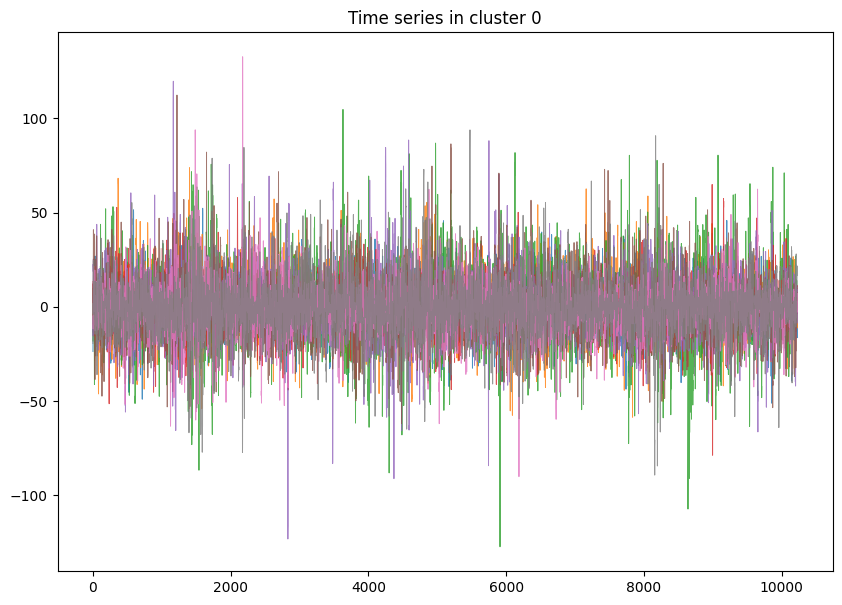

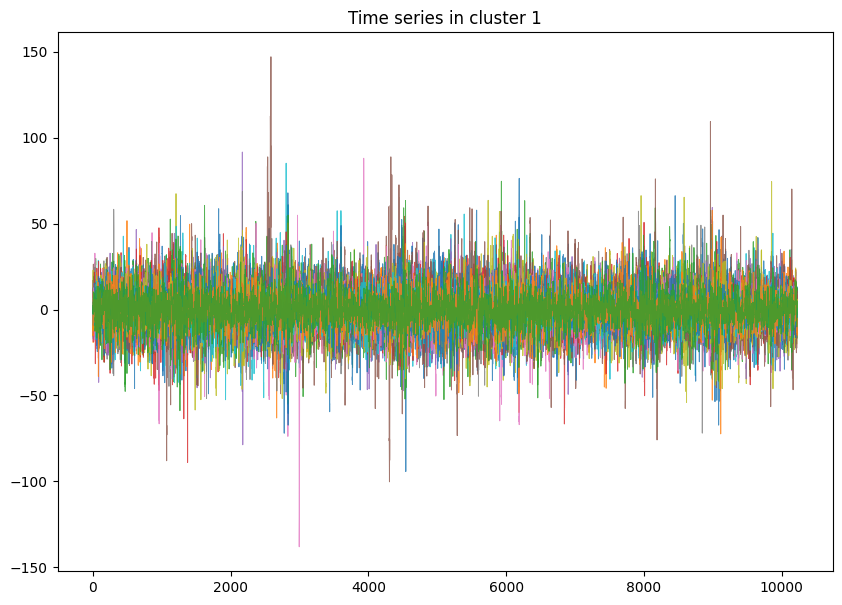

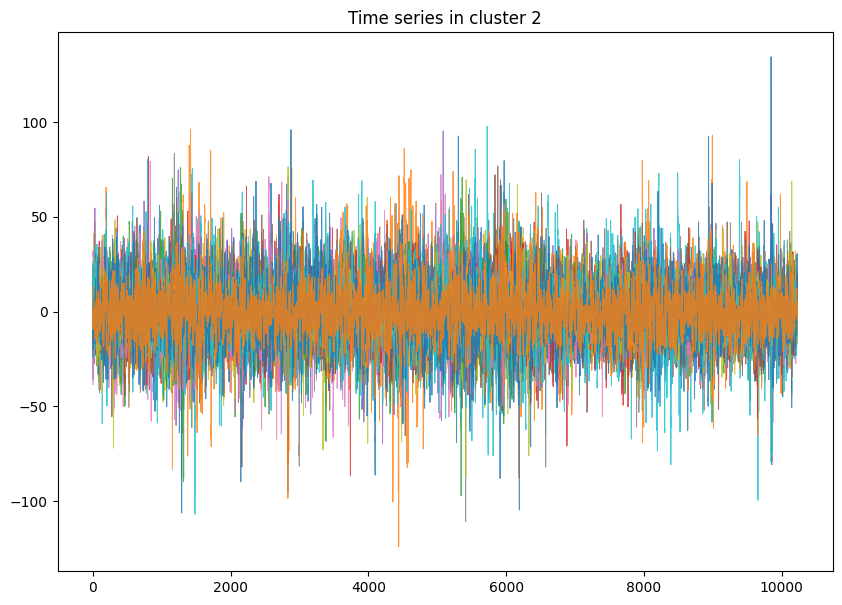

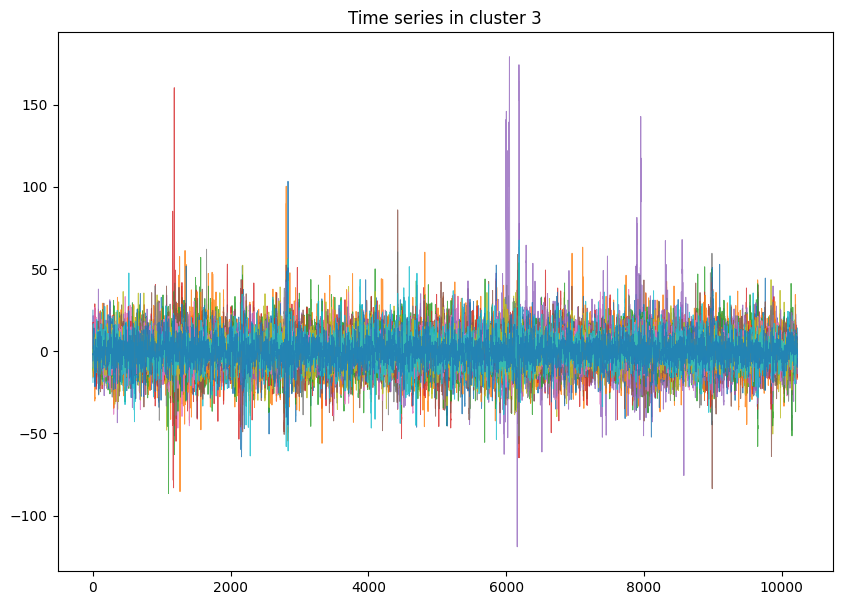

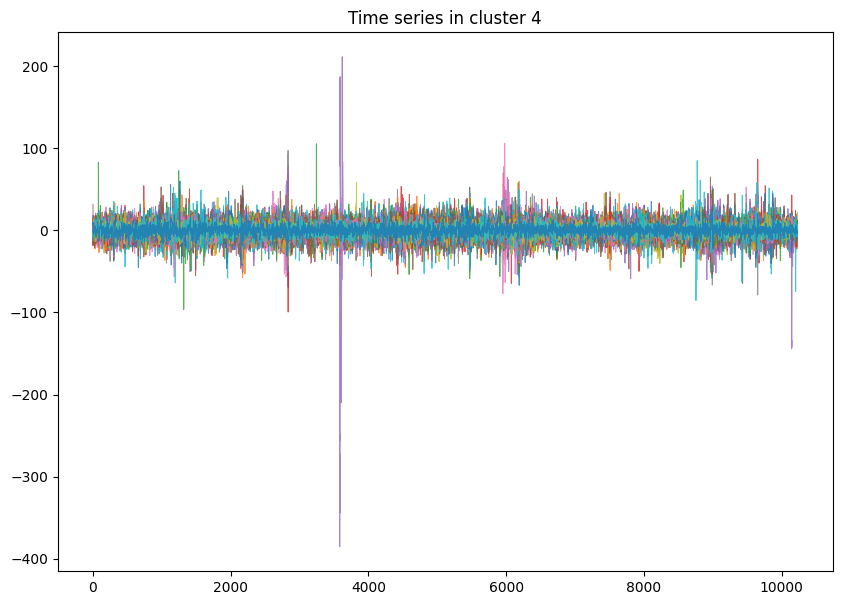

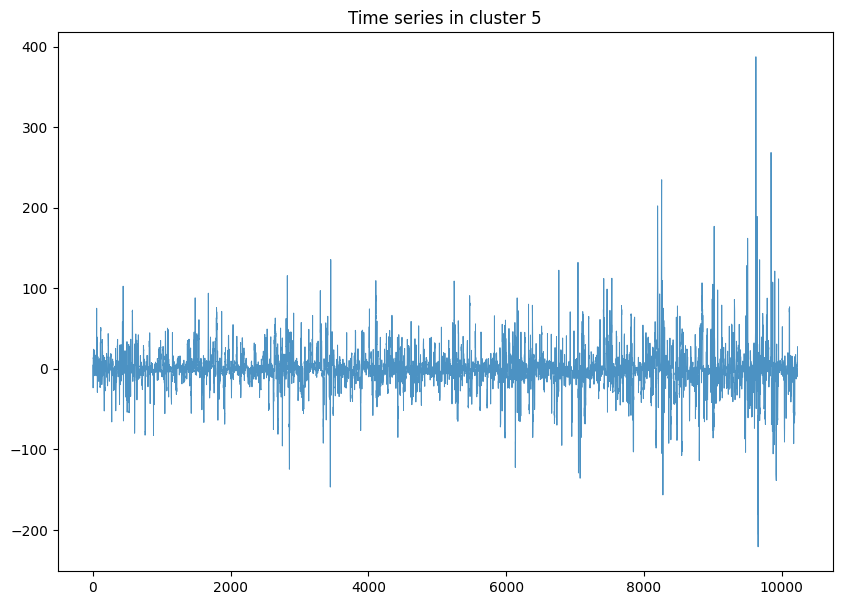

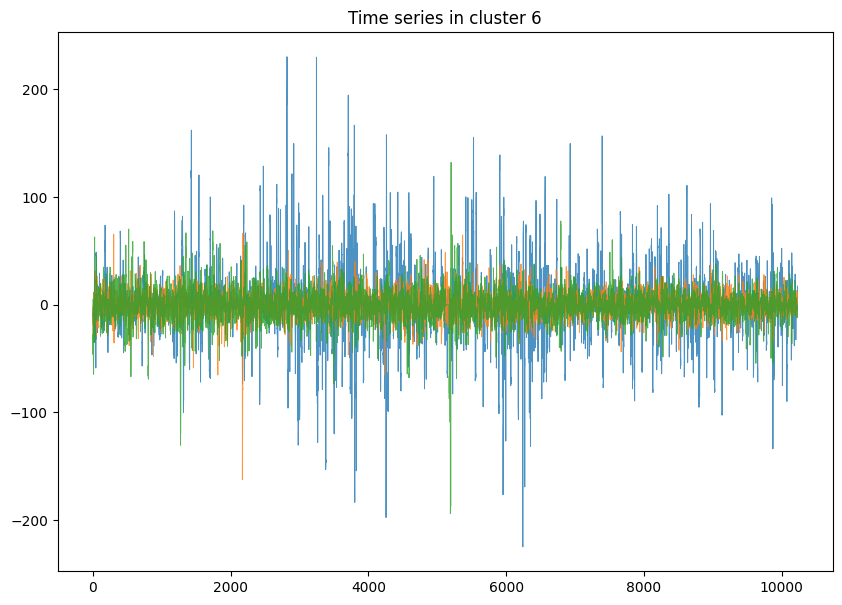

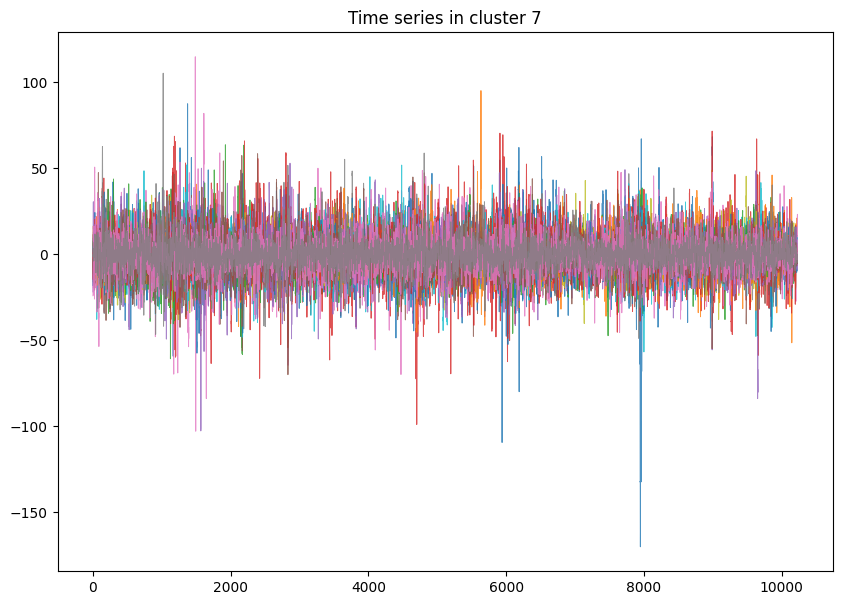

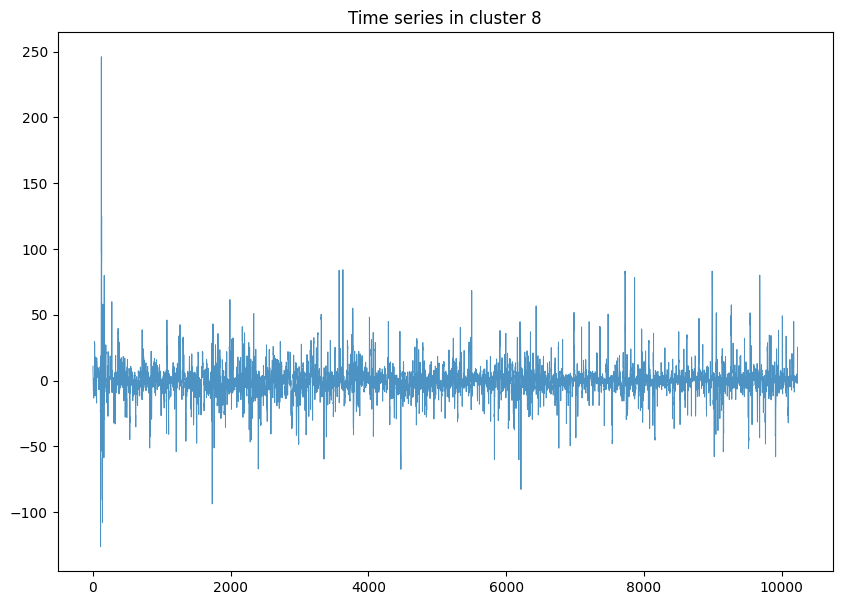

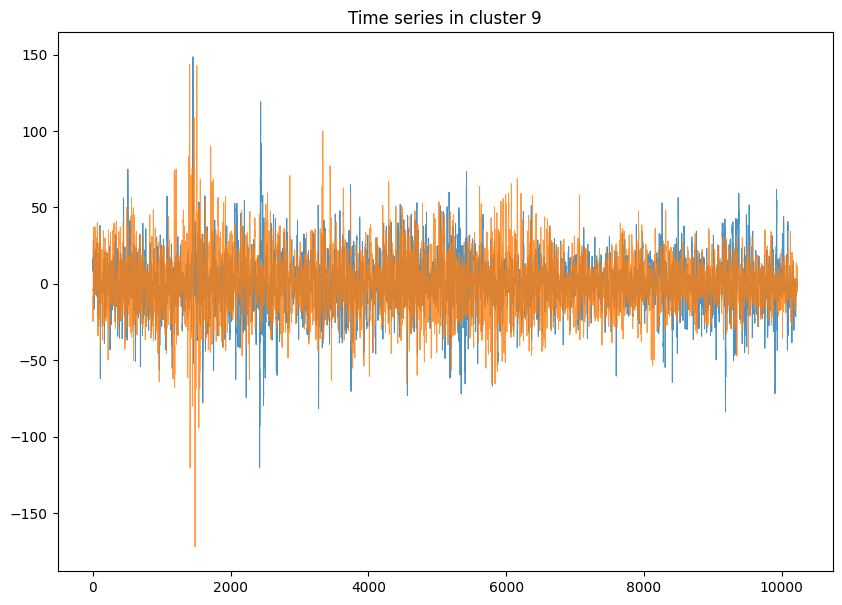

In [138]:
import matplotlib.pyplot as plt

# Get the labels from KMeans clustering
labels = kmeans.labels_

# Plot the time series according to their clusters
for i in range(10):  # change this to the number of clusters
    plt.figure(figsize=(10, 7))
    for j in range(len(labels)):
        if labels[j] == i:
            plt.plot(data_padded.iloc[j], alpha=0.8, lw=0.7)
    plt.title(f"Time series in cluster {i}")
    plt.show()

In [139]:
from sklearn.preprocessing import OneHotEncoder

# Create a DataFrame that maps 'stock_id' to its cluster label
cluster_labels = pd.DataFrame({
    'stock_id': data_padded.index,
    'cluster': labels
})

In [147]:
cluster_labels.to_csv('cluster_labels.csv', index=False)
cluster_labels

,stock_id,cluster
0,0,4
1,1,2
2,2,7
3,3,4
4,4,4
...,...,...
195,195,4
196,196,4
197,197,3
198,198,4


In [142]:
# Merge 'data' with 'cluster_labels' to add the 'cluster' column to 'data'
data = pd.merge(data, cluster_labels, on='stock_id', how='left')

In [115]:
data

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


# Check Performance of using clusters

In [117]:
# Generalized Linear Models Libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Competition Performance metric
from sklearn.metrics import mean_absolute_error

In [118]:
# train test split based on days
def split_data(data, n):
    train = data[data['date_id'] < n]
    test = data[data['date_id'] >= n]
    return train, test

def data_preprocessing(data, has_clusters=False):
    # replace missing values that correspond to undefined quantities with 0
    data['far_price']  = data['far_price'].fillna(0)
    data['near_price'] = data['near_price'].fillna(0)

    # identify columns with missing values
    columns_with_missing = data.columns[data.isnull().any()]

    # replace remaining missing values with variable median distribution
    for column in columns_with_missing:
        median_value = data[column].median()
        data[column] = data[column].fillna(median_value)

    # one hot encode categorical variable 'imbalance_buy_sell_flag'
    data = pd.get_dummies(data, columns=['imbalance_buy_sell_flag'], prefix='imbalance_flag')

    # rename the column 'imbalance_flag_-1' to 'imbalance_flag_neg_1' to be readable by formula
    data = data.rename(columns={'imbalance_flag_-1': 'imbalance_flag_neg_1'})
    
    if has_clusters:
        # one hot encode categorical variable 'imbalance_buy_sell_flag'
        data = pd.get_dummies(data, columns=['cluster'], prefix='cluster')
    
    return data

In [143]:
data_no_clusters = data_preprocessing(data, has_clusters=False)
data_clusters    = data_preprocessing(data, has_clusters=True)

In [120]:
data_clusters

,stock_id,date_id,seconds_in_bucket,imbalance_size,reference_price,matched_size,far_price,near_price,bid_price,bid_size,...,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,0,0,0,3180602.69,0.999812,13380276.64,0.000000,0.000000,0.999812,60651.50,...,False,False,False,False,False,True,False,False,False,False
1,1,0,0,166603.91,0.999896,1642214.25,0.000000,0.000000,0.999896,3233.04,...,False,False,False,False,False,False,True,False,False,False
2,2,0,0,302879.87,0.999561,1819368.03,0.000000,0.000000,0.999403,37956.00,...,False,False,False,False,False,False,False,False,True,False
3,3,0,0,11917682.27,1.000171,18389745.62,0.000000,0.000000,0.999999,2324.90,...,False,False,True,False,False,False,False,False,False,False
4,4,0,0,447549.96,0.999532,17860614.95,0.000000,0.000000,0.999394,16485.54,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,...,False,False,False,False,False,False,False,False,False,True
5237976,196,480,540,349510.47,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,...,False,False,True,False,False,False,False,False,False,False
5237977,197,480,540,0.00,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,...,False,False,False,False,False,False,False,False,False,True
5237978,198,480,540,1000898.84,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,...,False,False,False,False,False,False,False,False,True,False


In [144]:
n_split = 420

# split data into train and test set
train_set, test_set = split_data(data_no_clusters, n=n_split)
train_set_cluster, test_set_cluster = split_data(data_clusters, n=n_split)

x_test         = test_set.drop(columns=['target'])
x_test_cluster = test_set_cluster.drop(columns=['target'])

y_test         = test_set.target

## Linear Regression without clusters

In [122]:
# Define your formula here. For example, if 'target' is your target variable and 'stock_id', 'date_id' are your predictors, then formula would be 'target ~ stock_id + date_id'
formula = 'target ~ seconds_in_bucket + imbalance_size + reference_price + matched_size + far_price + near_price + bid_price + bid_size + ask_price + ask_size + wap + imbalance_flag_neg_1 + imbalance_flag_0 + imbalance_flag_1'

# Fit the model on training data
model_v1 = smf.ols(formula, data=train_set)
model_v1 = model_v1.fit()

# Predict on test data
y_pred = model_v1.predict(x_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Absolute Error for Linear Regression: {mae}')

Mean Absolute Error for Linear Regression: 5.784651014256962


## Linear Regression with clusters

In [145]:
# Define your formula here. For example, if 'target' is your target variable and 'stock_id', 'date_id' are your predictors, then formula would be 'target ~ stock_id + date_id'
formula = 'target ~ cluster_0 + cluster_1 + cluster_2 + cluster_3 + cluster_4 + cluster_5 + cluster_6 + cluster_7 + cluster_8 + cluster_9 + seconds_in_bucket + imbalance_size + reference_price + matched_size + far_price + near_price + bid_price + bid_size + ask_price + ask_size + wap + imbalance_flag_neg_1 + imbalance_flag_0 + imbalance_flag_1'

# Fit the model on training data
model_v1 = smf.ols(formula, data=train_set_cluster)
model_v1 = model_v1.fit()

# Predict on test data
y_pred = model_v1.predict(x_test_cluster)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Absolute Error for Linear Regression: {mae}')

Mean Absolute Error for Linear Regression: 5.7860517971844185


I think that a better idea would have been to cluster the stocks according to the distribution of the target, instead of trying to cluster according to the target time series, because if we cluster according to the target distribution then we would group stocks according to 'volatility'